In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
priceData = pd.read_csv("./data/processed/pricesList.csv")
rainfallData = pd.read_csv("./data/processed/rainfallData.csv")

In [3]:
# extract only one vegetable for the prediction
priceData = priceData[priceData["Name"] == "Potatoes_Local_POTATOES_1Kg"]

In [4]:
def featureEngineering(data):
    data2 = data.copy()
    # iterate through the rainfallData and add the rainfall to the priceData
    # for index, row in rainfallData.iterrows():
    #     # match the year and month from the rainfall data to the pricedata
    #     year = row['year']
    #     month = row['month']
    #     data2.loc[(data2['Year'] == year) & (data2['Month'] == month), 'anuradhapura'] = row['anuradhapura']
    #     data2.loc[(data2['Year'] == year) & (data2['Month'] == month), 'jaffna'] = row['jaffna']
    #     data2.loc[(data2['Year'] == year) & (data2['Month'] == month), 'nuwaraeliya'] = row['nuwaraeliya']

    return data2
    

In [5]:
def extractDate(data):
    data2 = data.copy()
    data2["Datetime"] = pd.to_datetime(data2[['Year', 'Month']].assign(day=(data2["Week"]-1)*7 +1))
    data2 = data2.set_index('Datetime')
    return data2

In [6]:
def preprocessData(data):
    data2 = data.copy()
    data2 = data2.dropna()
    return data2

In [7]:
# Removing outliers
from scipy.stats import gaussian_kde
def remove_outliers_kde(df, column_name, threshold=0.05):
    # Extract the values of the column
    column_values = df[column_name].values
    
    # Fit the kernel density estimation
    kde = gaussian_kde(column_values)
    
    # Evaluate the KDE for each data point
    density = kde.evaluate(column_values)
    
    # Sort the data points by their density values
    sorted_indices = np.argsort(density)
    
    # Calculate the threshold index based on the given threshold
    threshold_index = int(len(sorted_indices) * threshold)
    
    # Get the indices of non-outliers
    non_outlier_indices = sorted_indices[threshold_index:]
    
    # Filter out the non-outliers
    df_cleaned = df.iloc[non_outlier_indices]
    df_cleaned = df_cleaned.reset_index(drop=True)
    return df_cleaned

In [8]:
df = featureEngineering(priceData);
df = preprocessData(df);
# df = remove_outliers_kde(df, 'Price')
df = extractDate(df)

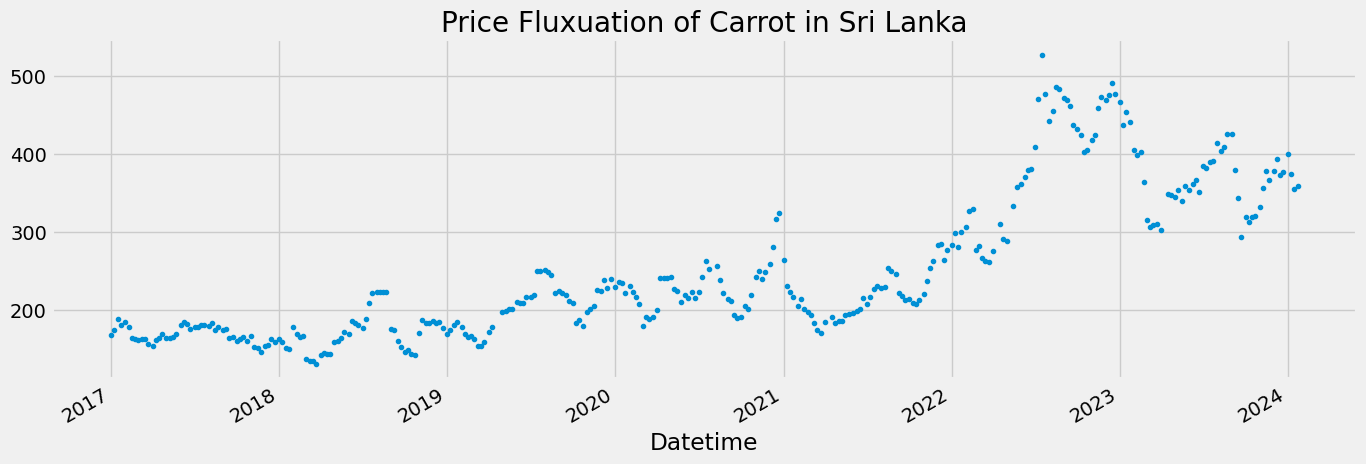

In [9]:
df["Price"].plot(style='.',figsize=(15, 5), title="Price Fluxuation of Carrot in Sri Lanka")
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 333 entries, 2017-01-01 to 2024-01-22
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    333 non-null    object 
 1   Price   333 non-null    float64
 2   Week    333 non-null    int64  
 3   Month   333 non-null    int64  
 4   Year    333 non-null    int64  
 5   Season  333 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 18.2+ KB


In [11]:
split_date = "2022-08-01"
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

/tmp/ipykernel_119661/3626683806.py:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend("Training set", "Test Set")


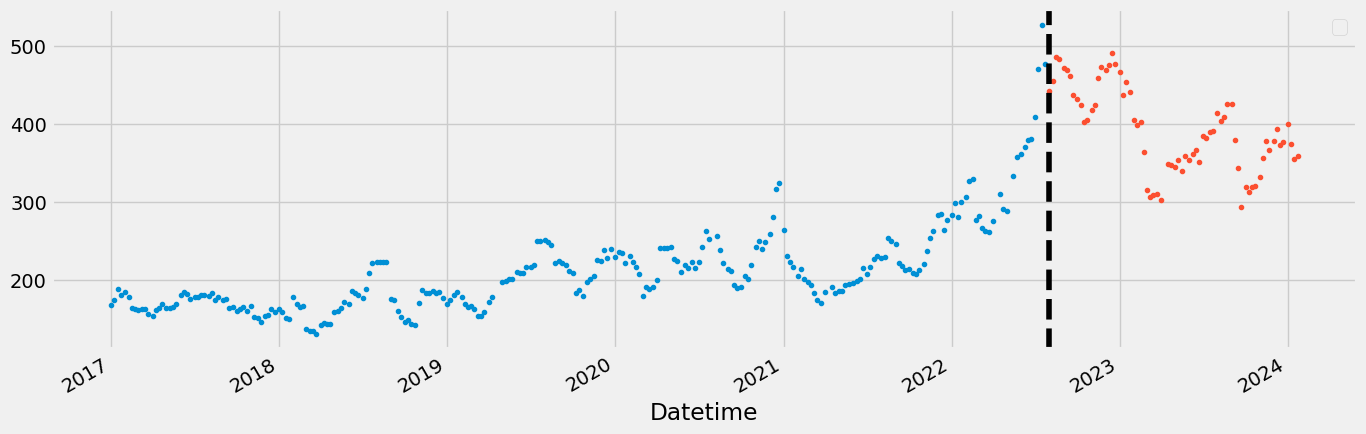

In [12]:
fix, ax = plt.subplots(1, 1, figsize=(15, 5))
train['Price'].plot(ax=ax, label="Train Set", style=".")
test['Price'].plot(ax=ax, label="Test Set", style=".")
ax.axvline(split_date, color="black", ls="--")
ax.legend("Training set", "Test Set")
plt.show()

<Axes: title={'center': 'Price Fluxuation of Carrot in Sri Lanka'}, xlabel='Datetime'>

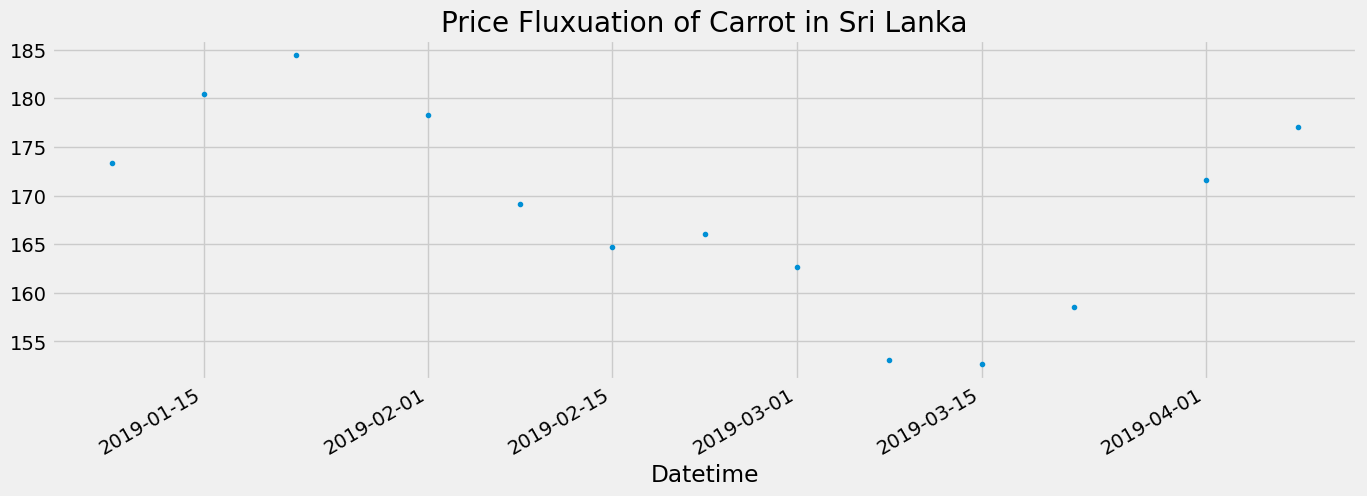

In [13]:
# plot week of data
df["Price"].loc[(df.index > "2019-01-01") & (df.index < "2019-05-01")].plot(style=".", figsize=(15, 5), title="Price Fluxuation of Carrot in Sri Lanka")

In [14]:
df.columns

Index(['Name', 'Price', 'Week', 'Month', 'Year', 'Season'], dtype='object')

In [15]:
FEATURES = ["Week", "Month", "Year", 
            # "anuradhapura", 
            # "jaffna", 
            # "nuwaraeliya"
            ]
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [19]:
# Model Creation
reg = xgb.XGBRegressor(n_estimators=10000, learning_rate=0.001)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=2500,verbose=50)
# reg.fit(X_test, y_test)

[0]	validation_0-rmse:57.34764	validation_1-rmse:188.88714
[50]	validation_0-rmse:55.02625	validation_1-rmse:181.52474


[100]	validation_0-rmse:52.82029	validation_1-rmse:174.52704
[150]	validation_0-rmse:50.72428	validation_1-rmse:167.87944
[200]	validation_0-rmse:48.73344	validation_1-rmse:161.56798
[250]	validation_0-rmse:46.84976	validation_1-rmse:155.57907


/home/iddhi/.local/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[300]	validation_0-rmse:45.06936	validation_1-rmse:149.89987
[350]	validation_0-rmse:43.38108	validation_1-rmse:144.51797
[400]	validation_0-rmse:41.77060	validation_1-rmse:138.92985
[450]	validation_0-rmse:40.23581	validation_1-rmse:133.49828
[500]	validation_0-rmse:38.77557	validation_1-rmse:128.37127
[550]	validation_0-rmse:37.38615	validation_1-rmse:123.52749
[600]	validation_0-rmse:36.04868	validation_1-rmse:118.92111
[650]	validation_0-rmse:34.77936	validation_1-rmse:114.57204
[700]	validation_0-rmse:33.57056	validation_1-rmse:110.49051
[750]	validation_0-rmse:32.41030	validation_1-rmse:106.66077
[800]	validation_0-rmse:31.29708	validation_1-rmse:103.07357
[850]	validation_0-rmse:30.22774	validation_1-rmse:99.72750
[900]	validation_0-rmse:29.21369	validation_1-rmse:96.60851
[950]	validation_0-rmse:28.24880	validation_1-rmse:93.72613
[1000]	validation_0-rmse:27.33008	validation_1-rmse:91.05711
[1050]	validation_0-rmse:26.45267	validation_1-rmse:88.72060
[1100]	validation_0-rmse:25

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
# evaluate the model
y_pred = reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")
# score
score = reg.score(X_test, y_test)
print(f"Score: {score}")

RMSE: 4871.918457803066
Score: -0.7224034693174652


In [22]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(bootstrap=True, criterion='poisson',max_depth=None, max_leaf_nodes=None,n_estimators=10000, random_state=None, n_jobs=1, verbose=0)
reg.fit(X_train, y_train)
# reg.fit(X_test, y_test)

RandomForestRegressor(criterion='poisson', n_estimators=10000, n_jobs=1)

In [25]:
from catboost import CatBoostRegressor

reg = CatBoostRegressor(iterations=70000, depth=5, learning_rate=0.001, loss_function='RMSE')
reg.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)
# reg.fit(X_test, y_test)

0:	learn: 57.3580686	test: 188.9127044	best: 188.9127044 (0)	total: 55ms	remaining: 1h 4m 7s
100:	learn: 54.1840153	test: 180.1086976	best: 180.1086976 (100)	total: 92.2ms	remaining: 1m 3s
200:	learn: 51.1610345	test: 171.5983564	best: 171.5983564 (200)	total: 102ms	remaining: 35.3s
300:	learn: 48.4578356	test: 163.8625397	best: 163.8625397 (300)	total: 113ms	remaining: 26.1s
400:	learn: 45.9506427	test: 156.6204576	best: 156.6204576 (400)	total: 123ms	remaining: 21.3s
500:	learn: 43.6425143	test: 149.7549517	best: 149.7549517 (500)	total: 133ms	remaining: 18.4s
600:	learn: 41.5435778	test: 143.4865072	best: 143.4865072 (600)	total: 143ms	remaining: 16.5s
700:	learn: 39.6509710	test: 137.4637515	best: 137.4637515 (700)	total: 151ms	remaining: 14.9s
800:	learn: 37.8494321	test: 131.5137652	best: 131.5137652 (800)	total: 160ms	remaining: 13.8s
900:	learn: 36.1980393	test: 126.4825215	best: 126.4825215 (900)	total: 170ms	remaining: 13s
1000:	learn: 34.7331397	test: 121.6505847	best: 121.6

In [ ]:
from prophet import Prophet
model = Prophet()
model.fit(train.reset_index().rename(columns={"Datetime": "ds", "Price": "y"}))
forecast = model.predict(test.reset_index().rename(columns={"Datetime": "ds", "Price": "y"}))

In [ ]:
fix, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(forecast, ax=ax)
plt.show()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.scatter(test.index, test["Price"], color="r", label="True Price")
fig = model.plot(forecast, ax=ax)
plt.show()


<Axes: xlabel='Datetime'>

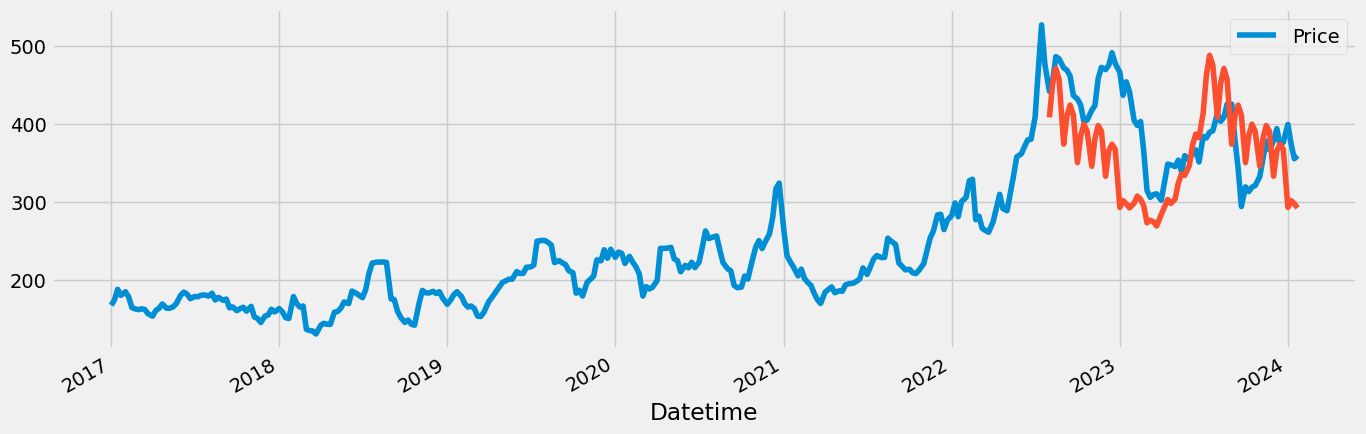

In [27]:
# forecast on test
style = "-"
test2 = test.copy()
test2["prediction"] = reg.predict(X_test)
df2 = df.merge(test2[["prediction"]], how="left", left_index=True, right_index=True)
ax = df2[["Price"]].plot(style=style, figsize=(15,5))
df2["prediction"].plot(style=style, ax=ax)

<Axes: xlabel='Datetime'>

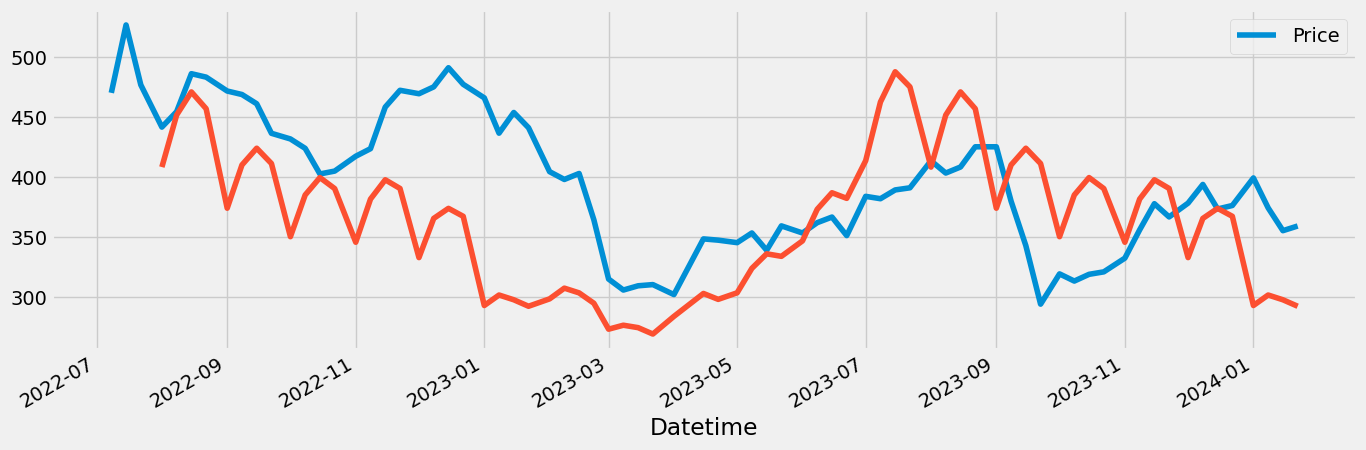

In [28]:
ax = df2.loc[(df2.index > "2022-07-01") & (df2.index < "2025-01-01")][["Price"]].plot(figsize=(15,5), style=style)
df2.loc[(df2.index > "2022-07-01") & (df2.index < "2025-01-01")]["prediction"].plot(ax=ax, style=style)

In [29]:
# model refit
X_train_copy = X_train.copy()
X_train_copy = pd.concat([X_train_copy, X_test.loc[X_test.index < "2023-12-01"].copy()])
y_train_copy = y_train.copy()
y_train_copy = pd.concat([y_train_copy, y_test.loc[y_test.index < "2023-12-01"].copy()])
reg.fit(X_train_copy, y_train_copy)

0:	learn: 92.2247163	total: 30.6ms	remaining: 35m 41s
1:	learn: 92.1570897	total: 30.8ms	remaining: 17m 57s
2:	learn: 92.0974301	total: 30.9ms	remaining: 12m 1s
3:	learn: 92.0307356	total: 31ms	remaining: 9m 2s
4:	learn: 91.9641204	total: 31.1ms	remaining: 7m 15s
5:	learn: 91.8985435	total: 31.2ms	remaining: 6m 4s
6:	learn: 91.8311189	total: 31.3ms	remaining: 5m 12s
7:	learn: 91.7655778	total: 31.4ms	remaining: 4m 34s
8:	learn: 91.7013901	total: 31.5ms	remaining: 4m 4s
9:	learn: 91.6391657	total: 31.6ms	remaining: 3m 41s
10:	learn: 91.5738327	total: 31.7ms	remaining: 3m 21s
11:	learn: 91.5051382	total: 31.8ms	remaining: 3m 5s
12:	learn: 91.4344267	total: 31.9ms	remaining: 2m 51s
13:	learn: 91.3681476	total: 32ms	remaining: 2m 40s
14:	learn: 91.2974976	total: 32.1ms	remaining: 2m 29s
15:	learn: 91.2320220	total: 32.2ms	remaining: 2m 20s
16:	learn: 91.1707727	total: 32.3ms	remaining: 2m 13s
17:	learn: 91.1098041	total: 32.4ms	remaining: 2m 6s
18:	learn: 91.0441493	total: 32.5ms	remaining

# Arima

In [30]:
from pmdarima import auto_arima

In [31]:
df2 = df.copy()
stepwise_fit = auto_arima(df2["Price"], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2753.401, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2763.546, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2754.402, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2753.351, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2762.010, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2755.270, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2755.243, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2756.994, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2751.694, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2753.621, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2753.598, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2752.731, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2755.333, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.629 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  333
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1373.847
Date:                Thu, 14 Mar 2024   AIC                           2751.694
Time:                        02:05:02   BIC                           2759.304
Sample:                             0   HQIC                          2754.729
                                - 333                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1978      0.041      4.877      0.000       0.118       0.277
sigma2       230.0203     11.936     19.271      0.000     206.626     253.415
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               104.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               4.84   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
model = ARIMA(train["Price"], order=(2,1,2))
model = model.fit()
model.summary()

/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  262
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1054.587
Date:                Thu, 14 Mar 2024   AIC                           2119.174
Time:                        02:05:07   BIC                           2136.997
Sample:                             0   HQIC                          2126.338
                                - 262                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9034      0.334     -2.704      0.007      -1.558      -0.249
ar.L2          0.0934      0.331      0.282      0.778      -0.555       0.742
ma.L1          1.0864      0.372      2.924      0.003       0.358       1.815
ma.L2          0.0910      0.362      0.251      0.802      -0.619       0.801
sigma2       189.2380     12.732     14.863      0.000     164.283     214.193
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               244.65
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.91   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
start = len(train)
end = len(train) + len(test) - 1
predictions = model.predict(start=start, end=end, typ="levels").rename("ARIMA Predictions")
predictions.index = test.index
print(predictions)

Datetime
2022-08-01    467.001484
2022-08-08    465.685091
2022-08-15    465.971636
2022-08-22    465.589860
2022-09-01    465.961516
                 ...    
2023-12-22    465.930396
2024-01-01    465.621052
2024-01-08    465.929486
2024-01-15    465.621960
2024-01-22    465.928582
Name: ARIMA Predictions, Length: 71, dtype: float64


/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/iddhi/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Datetime'>

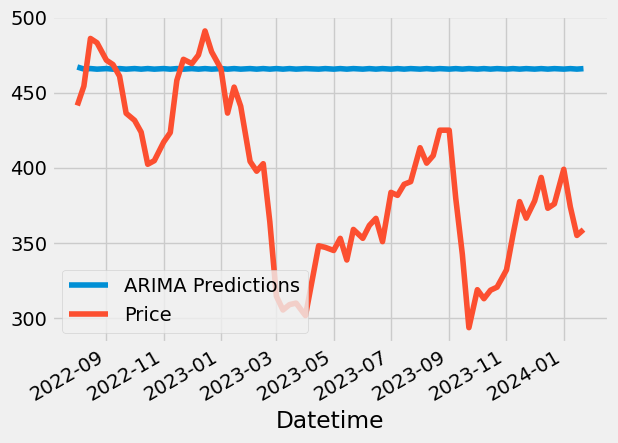

In [36]:
predictions.plot(legend=True)
test["Price"].plot(legend=True)

# Time series cross validation

In [37]:
from sklearn.model_selection import TimeSeriesSplit

In [38]:
tss = TimeSeriesSplit(n_splits=5, test_size=1, gap=0)
df3 = df.copy().sort_index()

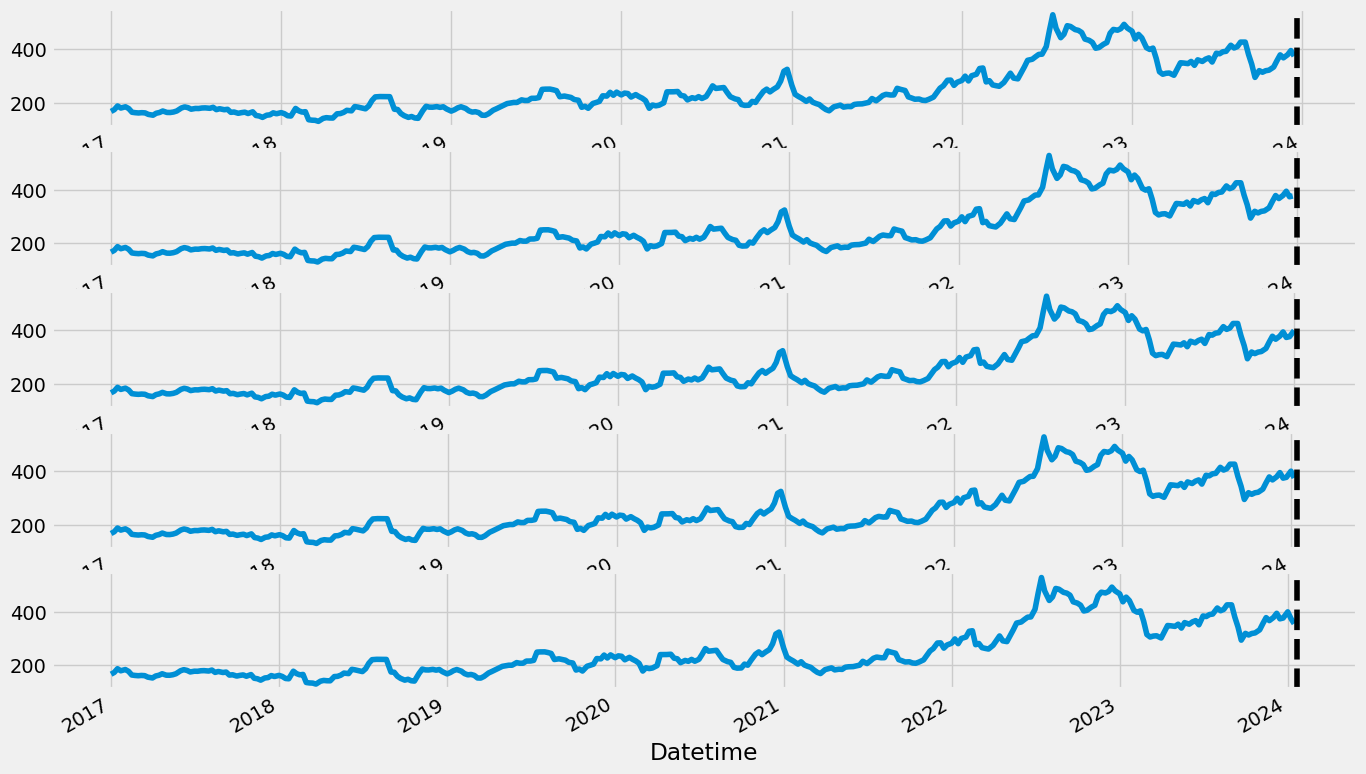

In [39]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10))
fold = 0
for train_index, test_index in tss.split(df3):
    train = df3.iloc[train_index]
    test = df3.iloc[test_index]
    train["Price"].plot(ax=axs[fold], label="Train")
    test["Price"].plot(ax=axs[fold], label="Test")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1